# 1、导入所需环境包

In [1]:
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

# 2、获取和整理数据集

比赛数据集分为训练集和测试集，分别包含RGB彩色通道的10222张、10357张JPEG图像

In [2]:
data_dir = '../traindata/'  # 命名数据集地址

In [3]:
labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))

# 3、整理数据集

像项目2那样整理数据集，从原始训练集中炒粉验证集，然后将图像移动到按标签分组的子文件夹中

In [4]:
def reorg_dog_data(data_dir, valid_ratio):
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))  # os.path.join返回路径，读取csv文件
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)  
                                                  # reorg_train_valid是2项目定义的函数，用于将验证集从原始的训练集中拆分出来。
    d2l.reorg_test(data_dir)                      # reorf_test函数用于在预测期间整理测试集，以方便读取。

batch_size = 512                                  # 批量大小为512
valid_ratio = 0.1                                 # 训练集中拆分出的验证集比例
# reorg_dog_data(data_dir, valid_ratio)           # 运行整理数据集的函数，已经运行过了，不需要在运行了

# 4、图像增广

在相对大一些的数据集上进行数据增广

In [5]:
transform_train = torchvision.transforms.Compose([  
                                                # transforms.Compose为整合图片变换的操作
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0), ratio=(3.0/4.0, 4.0/3.0)),
                                                # transforms.RandomResizeCorp函数对图片进行随机截取后在拉伸成笃定高宽
                                                # 其中224是输出图片的大小，也就是224*224的图像
                                                # scale是截取的面积大小比例，在0.08-1.0内随机截取原图
                                                #  ratio为截取图形的高宽比
    torchvision.transforms.RandomHorizontalFlip(),
                                                # 随机水品反转图像，默认翻转概率是0.5
    torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4,),
                                   # transforms.ColorJitter()改变的图像的属性，亮度brightness，对比度contras，饱和度saturation，色调hue
                                   # 其中bringhtness=0.4这以参数的意思是，将图像随机变化为原图40%的亮度，其他类似。
    torchvision.transforms.ToTensor(),           # 将图像转换为Tensor 
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    # 将tensor举证批量归一化，归一化的参数其实Normalize函数做的是将数据变换到了[-1,1]之间。之前的数据为0-1
                                    # 数据统一到[-1，1]有什么好处呢经过Normalize后，可以加快模型的收敛速度
])

测试时只使用确定性的图像预处理操作

In [6]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),                 # 重设图像尺寸为256*256 
    torchvision.transforms.CenterCrop(224),             # CenterCrop(224),表示从中心裁剪图片为224*224大小
    torchvision.transforms.ToTensor(),                  # 将图片转化为Tensor矩阵
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])# 将Tensor数据批量归一化
])

# 5、读取数据集

读取整理后的含原始图像文件的数据集

In [7]:
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]
# torchvision.datasets.ImageFolder是返回一个list，list中每一个值都是一个元组，元组包含图片的路径和标签 

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

# 有了image_datasets，然后依然用torch.utils.data.DataLoader类来做进一步封装，将这个batch的图像数据和标签都分别封装成Tensor。
# 到了这一步是将所有训练和验证的数据集准备完成。

# 6、微调预训练模型

In [8]:
def get_net(devices):
    finetune_net = nn.Sequential()  # 创建一个模型容器
    finetune_net.features = torchvision.models.resnet34(pretrained=True) # 容器的模型参数设置为已经经过预训练的resnet34
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256), 
                                            nn.ReLU(),
                                            nn.Linear(256, 102))
    # 在resnet34模型后面加上一个全连接层（1000入256出），和Relu层和一个全连接层120出也就是我们需要的分类数。
    finetune_net = finetune_net.to(devices[0])    # 将模型参数分配给用于计算的CPU或GPU
    for param in finetune_net.features.parameters():
        param.requires_grad = False    # 冻结参数
                                        # 不重新训练用于特征提取的预训练模型，这节省了梯度下降的时间和内存空间。
    return finetune_net

在[计算损失]之前，获取预训练模型的输出层的输入，即提取的特征。 然后使用此特征作为我们小型自定义输出网络的输入来计算损失。
也就是只计算自定义模型的损失

In [9]:
loss = nn.CrossEntropyLoss(reduction='none') # CorssEntropyLoss为交叉熵损失函数，具体是什么，查询
                                             # 损失函数中reduction参数主要影星多个样本输入时，损失的综合方法，mean表示损失为样本的平均值，
                                             # sum表示损失的和，none表示不综合也就是每个样本的损失
def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        features, labels = features.to(devices[0]), labels.to(devices[0])  # 将数据集features和labels转到显存中用于计算
        outputs = net(features)  # 将数据集中的训练特征输入到神经网络中计算得到输出结果outputs
        l = loss(outputs, labels)  # 将输出和数据集的标签进行交叉熵损失计算得到loss
        l_sum += l.sum()        # 将损失进行加和
        n += labels.numel()     # labels.sum()统计labels元素个数
        
    return (l_sum / n ).to('cpu') # 计算平均损失，并将数据传到cpu上

# 7、定义训练函数

根据模型在验证集上的表现选择模型并调整超参数，模型训练函数train值迭代自定义输出网络的参数

In [11]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    # 只训练小型自定义输出网络
    net = nn.DataParallel(net, device_ids=devices).to(devices[0]) # DataParallel用于多GPU计算，device_ids参数用于选择训练的GPU，
                                                                  # to函数将模型转到gpu上
    trainer = torch.optim.SGD((param for param in net.parameters() if param.requires_grad), lr=lr, momentum=0.9, weight_decay=wd)
         # SGD随机梯度下降，params时要训练的下降的参数，lr是学习率， 
        # momentum是动量，可以在更新参数的时候一定程度保留之前更新的方向，同时利用当前来微调方向，新的参数包含前一批次参数
        # weight_decay是权重衰退，避免过拟合，也就是为所有权重加个柔性限制，不让权重很大
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)# 定义学习率衰减参数，per为每几个epoch做一次衰减，de为衰减因子*
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss']
    if valid_iter is not None:
        legend.append('valid loss')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend)# 定义画图显示
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        for i, (features, labels) in enumerate(train_iter): # enumerate为给出元组前面的序号，
            timer.start()
            features, labels = features.to(devices[0]), labels.to(devices[0]) # 将数据集的特征和标签转到显存中
            trainer.zero_grad() # 将之前的梯度清零 于在PyTorch中，计算得到的梯度值会进行累加
            output = net(features) # 根据特征计算输出
            l = loss(output, labels).sum()
            l.backward()
            trainer.step()
            metric.add(l, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[1],None))
        measures = f'train loss {metric[0] / metric[1]:.3f}'
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss.detach().cpu()))
        scheduler.step()
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
    print(measures + f'\n{metric[1] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

# 8、训练和验证模型

现在我们可以训练和验证模型了，以下超参数都是可调的。 例如，我们可以增加迭代轮数。 另外，由于lr_period和lr_decay分别设置为2和0.9， 因此优化算法的学习速率将在每2个迭代后乘以0.9。

KeyboardInterrupt: 

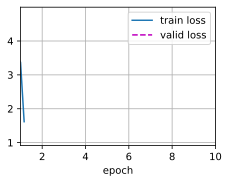

In [13]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 1e-4, 1e-4
lr_period, lr_decay, net = 2, 0.9, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

In [11]:
torch.save(net, 'dog.pth') # 保存模型的结构以及参数 

In [12]:
torch.save(net.state_dict(), 'net_model_wight.pth')

## 9、对测试集分类，并在kaggle提交结果

train loss 0.968
1524.6 examples/sec on [device(type='cuda', index=0)]


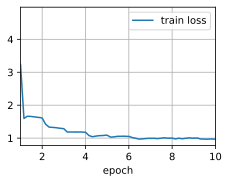

In [13]:
net = get_net(devices)
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

preds = []
for data, label in test_iter:
    output = torch.nn.functional.softmax(net(data.to(devices[0])), dim=1)
    preds.extend(output.cpu().detach().numpy())
ids = sorted(os.listdir(
    os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')))
with open('submission2-3.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_ds.classes) + '\n')
    for i, output in zip(ids, preds):
        f.write(i.split('.')[0] + ',' + ','.join(
            [str(num) for num in output]) + '\n')

## 10、预测单张图片输出结果

In [41]:
image_path = 'C:/deeplean/3/dog-breed-identification/train_valid_test/train/affenpinscher/1a012faf98b32039adc17ee708bcb360.jpg'

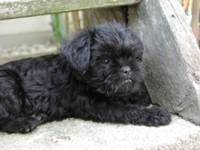

In [42]:

d2l.Image.open(image_path)

In [43]:
from PIL import Image

In [44]:
img = Image.open(image_path)
img_ = transform_test(img).unsqueeze(0)

In [66]:
img_ = img_.to(devices[0])


In [67]:
output = torch.nn.functional.softmax(net(data.to(devices[0])), dim=1)
preds.extend(output.cpu().detach().numpy())

In [68]:
preds

[array([3.85204437e-08, 4.18707060e-07, 6.20432664e-11, 1.11132541e-10,
        5.59566733e-11, 2.51591192e-09, 2.11554552e-09, 3.77709530e-10,
        4.03911404e-10, 1.30592270e-09, 1.02670043e-11, 3.80174576e-08,
        6.82825931e-12, 1.10881403e-03, 4.94652062e-11, 3.23613580e-10,
        3.65991291e-08, 1.52643981e-10, 1.69612770e-06, 2.56983004e-08,
        2.71505925e-11, 1.93319440e-08, 1.07018012e-08, 1.60675135e-08,
        4.38095014e-07, 1.55722310e-10, 9.05045205e-10, 8.19462220e-10,
        6.66897926e-11, 4.64340474e-06, 6.16628952e-08, 9.36991273e-06,
        6.35402512e-06, 2.75374219e-07, 2.42841576e-12, 8.23275448e-10,
        4.29741269e-12, 9.54583201e-13, 2.29345796e-12, 7.25363519e-11,
        1.81283482e-07, 2.83481086e-07, 4.27907126e-10, 3.16280530e-10,
        5.62529079e-10, 1.63774094e-09, 1.05889895e-12, 3.28010015e-11,
        1.57728032e-11, 7.12309234e-09, 7.25893581e-11, 5.60954061e-10,
        2.12391242e-07, 1.07177351e-08, 3.05469677e-11, 3.565464

In [69]:
train_valid_ds.classes

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [70]:
output

tensor([[7.1030e-08, 8.9119e-05, 9.9912e-01,  ..., 9.6816e-06, 4.4452e-08,
         3.3001e-08],
        [1.9033e-05, 6.2096e-06, 8.9779e-07,  ..., 1.4474e-05, 1.7453e-05,
         1.1249e-04],
        [1.6642e-06, 9.8214e-07, 6.3135e-07,  ..., 1.0255e-03, 1.0171e-05,
         5.7461e-06],
        ...,
        [5.2197e-08, 1.5295e-06, 1.1416e-04,  ..., 2.9955e-06, 2.7561e-08,
         3.2405e-07],
        [1.1277e-03, 2.3732e-07, 9.7527e-09,  ..., 2.4363e-08, 9.5543e-04,
         6.7691e-03],
        [1.1080e-07, 5.7522e-04, 2.8527e-07,  ..., 1.7884e-04, 5.3569e-07,
         8.5317e-08]], device='cuda:0', grad_fn=<SoftmaxBackward0>)